In [1]:
from jax import config
config.update('jax_enable_x64', True)

from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from uncprop.models.elliptic_pde.experiment import (
    PDEReplicate,
    summarize_status,
    load_rep,
    read_samp,
    samp_trace,
    samp_pair_plot,
    plot_surrogate_pred,
    estimate_mahalanobis_coverage,
    assemble_coverage_reps,
)

from uncprop.utils.plot import (
    set_plot_theme, 
    smart_subplots,
    plot_coverage_curve,
    plot_coverage_curve_reps,
)

colors = set_plot_theme()

experiment_name = 'pde_experiment'
base_dir = Path('/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates')
output_dir = base_dir / 'out' / 'final'
base_out_dir = base_dir / 'out'

/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
if not output_dir.exists():
    output_dir.mkdir()

summarize_status(base_out_dir, experiment_name, n_design=[10, 20, 30])

### Coverage plots

In [ ]:
ndesign = [10, 20, 30]
approx_dist_names = ['mean', 'eup', 'ep_mcwmh']
probs = jnp.linspace(0.1, 0.99, 10)

fig, axs = smart_subplots(nrows=3, ncols=3, flatten=False)

for n_idx, n in enumerate(ndesign):
    coverage_n = assemble_coverage_reps(base_out_dir, experiment_name, n_design=n, probs=probs, 
                                        approx_dist_names=approx_dist_names)

    for dist_idx, dist_name in enumerate(approx_dist_names):
        ax = axs[n_idx, dist_idx]
        dist_name = 'ep' if dist_name == 'ep_mcwmh' else dist_name
        plot_coverage_curve_reps(log_coverage=jnp.log(coverage_n)[:,[dist_idx],:], 
                                 probs=probs, 
                                 names=[dist_name],
                                 colors=colors,
                                 qmin=0.05,
                                 qmax=0.95,
                                 single_plot=True,
                                 ax=ax,
                                 alpha=0.2, max_cols=3)
        
        if n_idx == 0: # first row
            ax.set_title(dist_name, fontsize=ax.title.get_fontsize() * 1.8)
        if n_idx != (len(ndesign)-1): # all but final row
            ax.set_xlabel(None)
            # ax.set_xticklabels([])
        else:
            ax.set_xlabel('nominal', fontsize=ax.xaxis.label.get_size() * 1.8)
        if dist_idx != 0: # all but first column
            ax.set_ylabel(None)
            # ax.set_yticklabels([])
        else:
            ax.set_ylabel(f'actual (N = {n})', fontsize=ax.yaxis.label.get_size() * 1.8)

        ax.get_legend().remove()

fig.savefig(output_dir / 'pde_coverage.png', bbox_inches='tight')
display(fig)


### Investigate single replicate

In [ ]:
n_design = 30
rep_idx = 76

key = jr.key(231442)

rep = load_rep(base_out_dir, experiment_name, n_design, rep_idx)
samp = dict(read_samp(base_out_dir, experiment_name, n_design, rep_idx))

posterior = rep.posterior
posterior_surrogate = rep.posterior_surrogate

	Fitting surrogate


In [8]:
from uncprop.models.elliptic_pde.experiment import sample_rkpcn

key, key_init_pos, key_rkpcn = jr.split(key, 3)
initial_position = posterior.prior.sample(key_init_pos).squeeze()

prop_cov = jnp.cov(samp['eup'], rowvar=False)

samp_rkpcn = sample_rkpcn(key=key_rkpcn,
                          posterior=posterior,
                          surrogate_post=posterior_surrogate,
                          initial_position=initial_position,
                          prop_cov=prop_cov,
                          rho=0.99,
                          n_samples=5_000,
                          n_burnin=50_000,
                          thin_window=5)
samp['rkpcn'] = samp_rkpcn

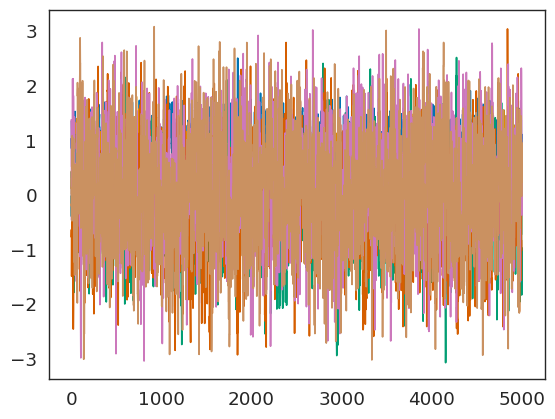

In [9]:
for i in range(6):
    plt.plot(samp_rkpcn[:,i])
plt.show()

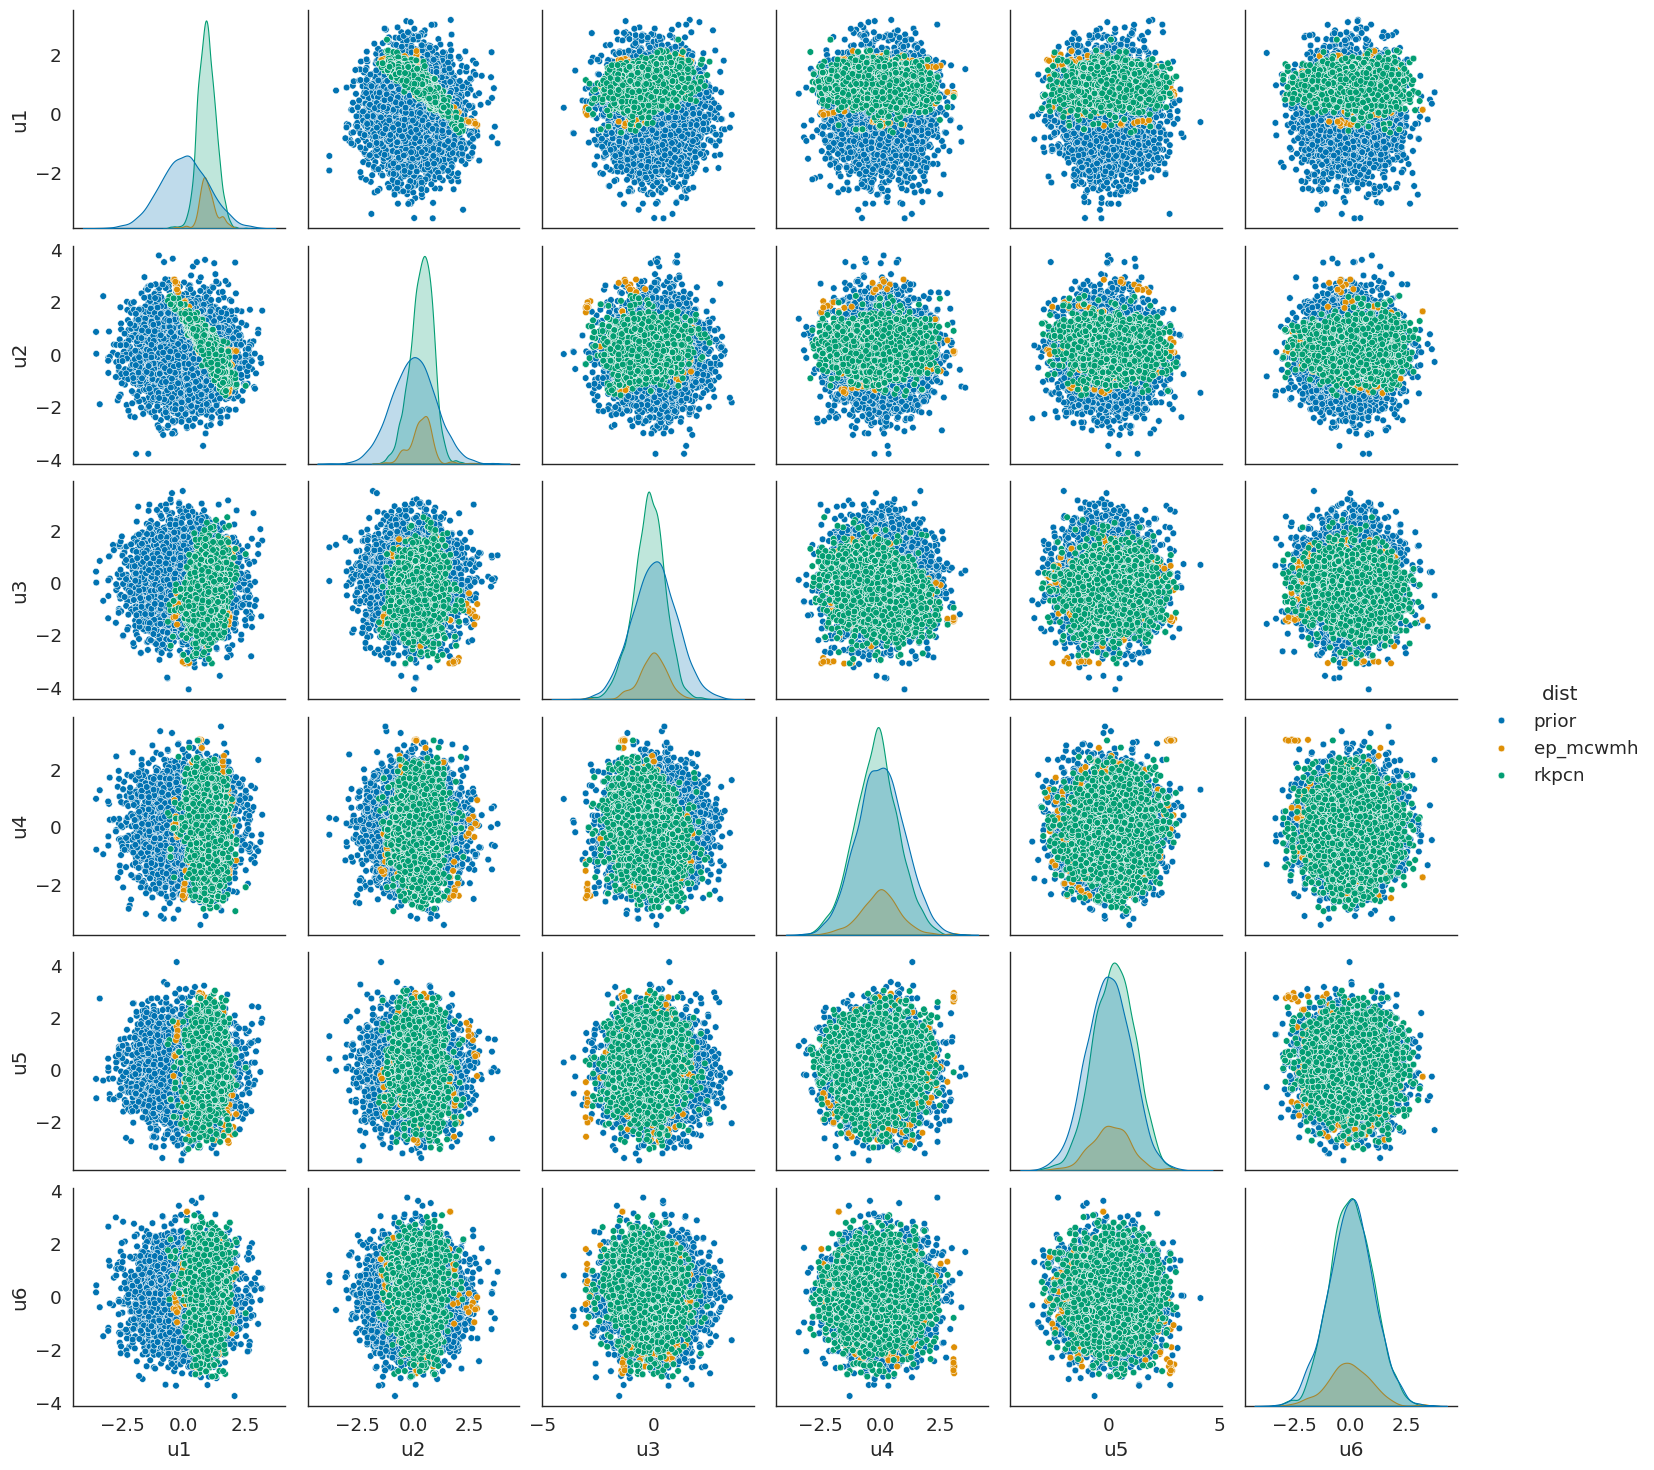

In [10]:
import pandas as pd

key, key_prior = jr.split(key)
samp['prior'] = jr.normal(key_prior, samp['exact'].shape) # N(0, I) prior

dist_names = ['prior', 'ep_mcwmh', 'rkpcn']
par_names = [f'u{i}' for i in range(1, samp['exact'].shape[1]+1)]

df_list = []
for name in dist_names:
    df = pd.DataFrame(samp[name], columns=par_names)

    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

In [ ]:
samp_trace(base_out_dir, experiment_name, n_design, rep_idx)

In [ ]:
samp_pair_plot(base_out_dir, experiment_name, 
               n_design=n_design, 
               rep_idx=rep_idx, dist_names=['prior', 'eup', 'exact'])

In [ ]:
samples = read_samp(base_out_dir, experiment_name, n_design, rep_idx)
probs = jnp.linspace(0.1, 0.99, num=10)

coverage = estimate_mahalanobis_coverage(samples=samples, 
                                         baseline='exact',
                                         probs=probs)

In [ ]:
log_coverage = jnp.log(jnp.stack([coverage[k] for k in coverage.keys()]))

fig_coverage, ax_coverage = plot_coverage_curve(log_coverage=log_coverage, 
                                                probs=probs, 
                                                names=list(coverage.keys()))

In [ ]:
plot_surrogate_pred(base_out_dir, experiment_name, 10, 1)

In [ ]:
from uncprop.core.distribution import DistributionFromDensity

observable_to_logdensity = posterior.likelihood.observable_to_logdensity
truncated_log_prior = DistributionFromDensity(log_dens=posterior.prior.log_density,
                                              dim=posterior.dim, support=posterior_surrogate.support)
truncated_log_prior_density = truncated_log_prior.log_density

def log_density(f, u):
    return observable_to_logdensity(f) + truncated_log_prior_density(u)

In [ ]:
from uncprop.core.samplers import mcmc_loop, init_rkpcn_kernel, _f_update_pcn_proposal
from typing import NamedTuple

key, key_init, key_init_pos, key_mcmc = jr.split(key, 4)

# settings for f update in sampler
class UpdateInfo(NamedTuple):
    rho: float
f_update_info = UpdateInfo(rho=0.99)

samp_exact = jnp.load(base_out_dir / experiment_name / f'n_design_{n_design}' / f'rep{rep_idx}' / 'samples.npz')['exact']
prop_cov = jnp.cov(samp_exact, rowvar=False)

init_fn, kernel = init_rkpcn_kernel(key=key_init, 
                                    log_density=log_density,
                                    gp=posterior_surrogate.surrogate,
                                    f_update_fn=_f_update_pcn_proposal,
                                    f_update_info=f_update_info)

In [ ]:
key, key_init_state, key_step = jr.split(key, 3)

initial_state = init_fn(key=key_init_state,
                        initial_position=posterior.prior.sample(key_init_pos).squeeze(),
                        prop_cov=prop_cov)

newstate, _ = kernel(key_step, initial_state)        

In [ ]:
samp_exact = jnp.load(base_out_dir / experiment_name / f'n_design_{n_design}' / f'rep{rep_idx}' / 'samples.npz')['exact']
prop_cov = jnp.cov(samp_exact, rowvar=False)

In [ ]:
samp = jnp.load(base_out_dir / experiment_name / f'n_design_{n_design}' / f'rep{rep_idx}' / 'samples.npz')
samp = dict(samp)
samp['rkpcn'] = samp_rkpcn